## Initiate the notebook and install the right modules
https://www.geopythontutorials.com/notebooks/xarray_zonal_stats.html

In [1]:
2+2

4

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from datetime import datetime
import dask
import regionmask
import geopandas as gpd
import utilities

# from importlib import reload # use this if the utilities.py file has changed in this instance of the notebook
# reload(utilities)

c:\Users\RossB\.conda\envs\forestHealth\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
################################
# Establish a Dask cluster for parallel processing
from dask.distributed import Client, progress, LocalCluster
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit='2GB'
)

client = Client(cluster)  # set up local cluster on the machine
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52331,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52375,Total threads: 4
Dashboard: http://127.0.0.1:52378/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:52334,


## Fetch the data and create an xarray

In [5]:
gdf = gpd.read_file('../data/inputs/h3.gpkg', layer='h3_elliott_river')

In [6]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
gdf.to_crs("EPSG: 4326").total_bounds.tolist()

[152.06257261574572,
 -25.218470756062715,
 152.4445749344499,
 -24.876538810999975]

In [8]:
# Select the first polygon with level == 5
# level_5_polygon = gdf[gdf['level'] == 5].iloc[1]

# Filter level == 10 polygons that are geographically contained within the selected level 5 polygon
# gdf_filtered = gdf[gdf['level'] == 10].loc[gdf[gdf['level'] == 10].geometry.within(level_5_polygon.geometry)]
gdf_filtered = gdf[gdf['level'] == 10]

# Update the gdf variable with the filtered result
# gdf = gdf_filtered

print(f"Original gdf had {len(gdf_filtered)} level 10 polygons within the selected level 5 polygon after filtering.")
display(gdf_filtered.head())

Original gdf had 4153 level 10 polygons within the selected level 5 polygon after filtering.


,GRID_ID,level,within0km,within10km,MERGE_SRC,geometry
193,8abe8b604007fff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16946953.399 -2874089.686, 169..."
194,8abe8b60400ffff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16946796.75 -2874072.967, 1694..."
195,8abe8b604017fff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16947047.023 -2873964.09, 1694..."
196,8abe8b60401ffff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16946890.376 -2873947.372, 169..."
197,8abe8b604027fff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16947016.423 -2874232.002, 169..."


In [9]:
resource = utilities.load_resource("../resources/pc-sentinel-2-l2a.yaml")

url = resource["url"]
sensor_name = resource["name"]
bands = resource["bands"]
print(f"Bands to be collected: {bands}")

bounds = gdf_filtered.to_crs("EPSG: 4326").total_bounds.tolist()

# time_range = "2017-01-01/2025-12-31"
# data = utilities.get_data_from_stac(
#     url=url,
#     bounds=bounds,
#     sensor_name=sensor_name,
#     sensor_bands=bands,
#     time_range=time_range)

from pystac_client import Client as StacClient
import planetary_computer
catalog = StacClient.open('https://planetarycomputer.microsoft.com/api/stac/v1/', modifier=planetary_computer.sign_inplace)

results = catalog.search(
    collections=[sensor_name],
    bbox=bounds,
    datetime=['2017-01-01', '2025-12-31'], # just from one year for now
    query={'eo:cloud_cover': {'lt': 20}}
)
items = list(results.items())
len(items), items[0] if items else None

Bands to be collected: ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'SCL']


(344, <Item id=S2C_MSIL2A_20251209T000231_R030_T56JMT_20251209T023809>)

In [11]:
# gdf_filtered.to_crs('EPSG:32756', inplace=True)

In [10]:
from odc.stac import stac_load

chunks = {'time': 1, 'x': 2048, 'y': 2048}
data = stac_load(items=items, bands=bands, bbox=bounds, groupby='time', chunks=chunks)
data

<xarray.Dataset> Size: 42GB
Dimensions:      (y: 1851, x: 1819, time: 309)
Coordinates:
  * y            (y) float64 15kB 7.239e+06 7.239e+06 ... 7.22e+06 7.22e+06
  * x            (x) float64 15kB 4.164e+05 4.164e+05 ... 4.345e+05 4.345e+05
  * time         (time) datetime64[us] 2kB 2017-01-25T00:02:11.026000 ... 202...
    spatial_ref  int32 4B 32756
Data variables:
    B02          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B03          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B04          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B05          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B06          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B07          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B08          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B11          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    B12          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>
    SCL          (time, y, x) float32 4GB dask.array<chunksize=(1, 1851, 1819), meta=np.ndarray>

In [11]:
data_monthly = utilities.resample_stac_data_to_data_monthly(data)
print(f"Raw data size {utilities.calculate_data_size_in_gb(data):.2g} GB, resampled to monthly size {utilities.calculate_data_size_in_gb(data_monthly):.2g} GB")

Raw data size 39 GB, resampled to monthly size 14 GB


## Calculate a mask

First, we need to convert the GeoDataFrame to a Xarray Dataset. We will be using the regionmask module that converts the geodataframe into an Xarray Dataset having dimension and coordinates same as of given input xarray dataset.

In [12]:
gdf_filtered['row_number'] = gdf_filtered.index
gdf_filtered.head()

,GRID_ID,level,within0km,within10km,MERGE_SRC,geometry,row_number
193,8abe8b604007fff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16946953.399 -2874089.686, 169...",193
194,8abe8b60400ffff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16946796.75 -2874072.967, 1694...",194
195,8abe8b604017fff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16947047.023 -2873964.09, 1694...",195
196,8abe8b60401ffff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16946890.376 -2873947.372, 169...",196
197,8abe8b604027fff,10,1,1.0,Y:\Projects\Ben\ForestHealth\ForestHealth.gdb\...,"MULTIPOLYGON (((16947016.423 -2874232.002, 169...",197


The solution to `ValueError: There are equal longitude coordinates (when wrapped)!` is to do the following...



Here is some code from earlier

```python
# gdf_filtered and data_monthly should now both be in EPSG:32756

# Verify CRS and bounds
print(f"gdf_filtered CRS: {gdf_filtered.crs}")
print(f"data_monthly CRS: {data_monthly.rio.crs}")

print(f"gdf_filtered bounds: {gdf_filtered.total_bounds}")
print(f"data_monthly bounds: {data_monthly.rio.bounds()}")

gdf_filtered.to_crs("EPSG: 32756", inplace=True)

# Create a 2D mask with region numbers using mask_geopandas
mask_2d_np = regionmask.mask_geopandas(
    gdf_filtered,
    data_monthly.x,
    data_monthly.y,
    numbers='row_number', # returns region numbers
    wrap_lon=False # Explicitly disable longitude wrapping for projected coordinates
)

# Convert the numpy mask to an xarray DataArray for use in groupby
mask_da = xr.DataArray(
    mask_2d_np,
    coords={'y': data_monthly.y, 'x': data_monthly.x},
    dims=['y', 'x']
)

print(f"Mask DataArray shape: {mask_da.shape}")
print(f"Number of non-NaN values in mask_da: {np.count_nonzero(~np.isnan(mask_da))}")
```

In [13]:
# gdf_filtered and data_monthly should now both be in EPSG:32756

# Verify CRS and bounds
print(f"gdf_filtered CRS: {gdf_filtered.crs}")
print(f"data_monthly CRS: {data_monthly.rio.crs}")

print(f"gdf_filtered bounds: {gdf_filtered.total_bounds}")
print(f"data_monthly bounds: {data_monthly.rio.bounds()}")

gdf_filtered.to_crs("EPSG: 32756", inplace=True)

mask = regionmask.mask_geopandas(
    gdf_filtered,
    data_monthly.x,
    data_monthly.y,
    # drop=True,
    numbers='row_number',
    overlap=False,
    wrap_lon=False # Explicitly disable longitude wrapping for projected coordinates
)

print(f"Mask shape: {mask.shape}")
print(f"Number of non-NaN values in mask: {np.count_nonzero(~np.isnan(mask))}")

gdf_filtered CRS: EPSG:3857
data_monthly CRS: EPSG:32756
gdf_filtered bounds: [16939643.0752 -2891783.4884 16959603.9759 -2871368.056 ]
data_monthly bounds: (416360.0, 7220340.0, 434550.0, 7238850.0)
Mask shape: (1851, 1819)
Number of non-NaN values in mask: 721483


Apply the mask on the dataset. Here is the previous code

```python
data_monthly = data_monthly.where(mask).chunk('auto')
```

This cell is no longer needed as the mask will be applied implicitly via groupby in the next step.
The previous approach caused a massive memory spike due to broadcasting a 3D mask.
```python
# data_monthly = data_monthly.where(mask).chunk('auto')
print("Mask application deferred to groupby step.")
```

Next we calculate zonal statistics on the masked DataArray.

In [14]:
# grouped = data_monthly.groupby('time').mean(['x','y'])
grouped = data_monthly.groupby(mask.rename('region')).mean('stacked_y_x')
grouped

<xarray.Dataset> Size: 18MB
Dimensions:      (region: 4153, time: 108)
Coordinates:
  * region       (region) float64 33kB 193.0 194.0 195.0 ... 4.344e+03 4.345e+03
  * time         (time) datetime64[us] 864B 2017-01-31 2017-02-28 ... 2025-12-31
    spatial_ref  int32 4B 32756
Data variables:
    B02          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B03          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B04          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B05          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B06          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B07          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B08          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B11          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B12          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    SCL          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>

Compute the result. Dask will now distribute the computation across all chunks using available workers.

In [15]:
%time grouped = grouped.compute()

c:\Users\RossB\.conda\envs\forestHealth\Lib\site-packages\distributed\client.py:3387: UserWarning: Sending large graph of size 1.13 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Exception: RasterioIOError('HTTP response code: 403')

Convert the results to a pandas dataframe

In [16]:
grouped

<xarray.Dataset> Size: 18MB
Dimensions:      (region: 4153, time: 108)
Coordinates:
  * region       (region) float64 33kB 193.0 194.0 195.0 ... 4.344e+03 4.345e+03
  * time         (time) datetime64[us] 864B 2017-01-31 2017-02-28 ... 2025-12-31
    spatial_ref  int32 4B 32756
Data variables:
    B02          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B03          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B04          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B05          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B06          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B07          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B08          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B11          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    B12          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>
    SCL          (region, time) float32 2MB dask.array<chunksize=(1, 1), meta=np.ndarray>

In [17]:
stats = grouped.to_dataframe().reset_index()
stats.head()

c:\Users\RossB\.conda\envs\forestHealth\Lib\site-packages\distributed\client.py:3387: UserWarning: Sending large graph of size 102.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Exception: RasterioIOError('HTTP response code: 403')

In [36]:
# stats['region'].nunique()
# stats['time'].nunique()

701

In [ ]:
# save out the results so we don't lose anything
stats.to_csv('../data/outputs/stats_elliott_river_2017_2025.csv')

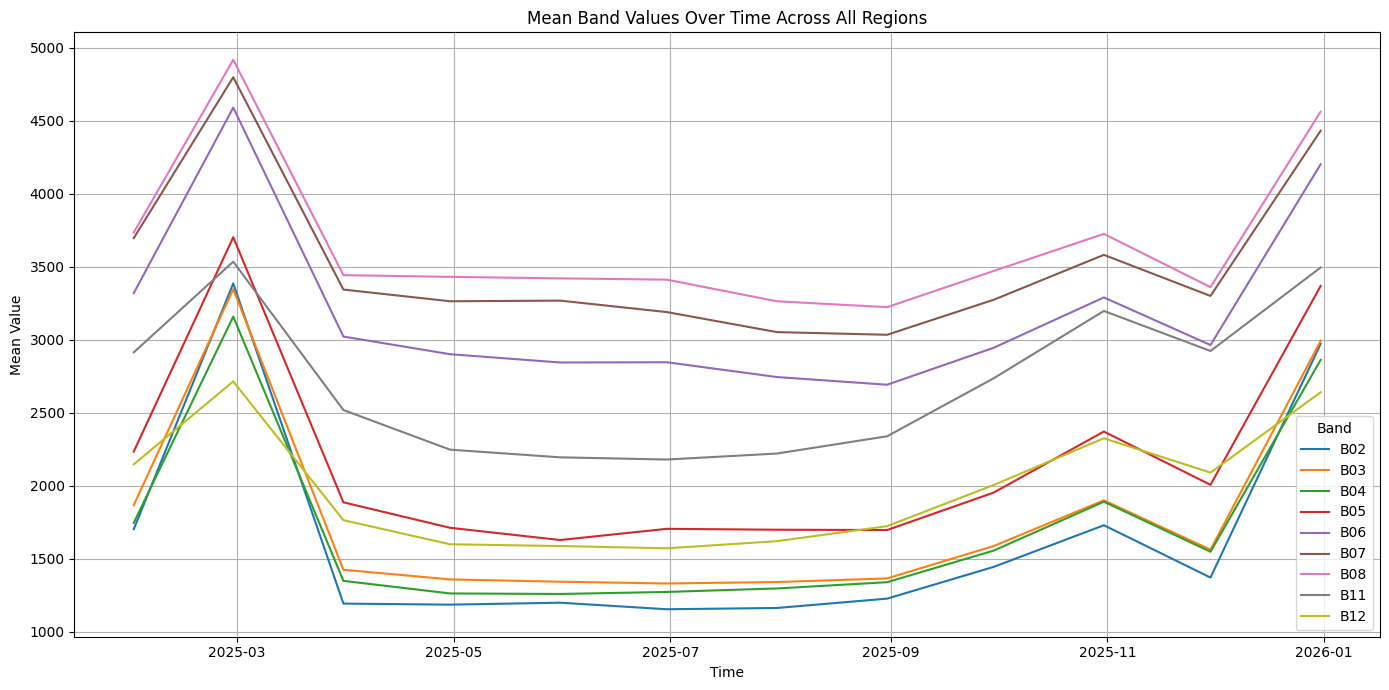

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify the columns representing the bands (excluding 'time' and 'region')
data_columns = [col for col in stats.columns if col not in ['time', 'region', 'SCL', 'spatial_ref']]

# Calculate the mean of each band across all regions for each time step
stats_mean_over_regions = stats.groupby('time')[data_columns].mean().reset_index()

# Melt the DataFrame to a long format suitable for plotting multiple lines
stats_melted = stats_mean_over_regions.melt(id_vars=['time'], var_name='Band', value_name='Mean Value')

# Create the line chart using seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=stats_melted, x='time', y='Mean Value', hue='Band')
plt.title('Mean Band Values Over Time Across All Regions')
plt.xlabel('Time')
plt.ylabel('Mean Value')
plt.grid(True)
plt.tight_layout()
plt.show()